# Connecting IFR theory to connectionism

From the IFR experiments, we can see how the IFR is governed as a function of input current. We derived a formula for the IFR, which assumes that the current input into the neuron is constant. However, this approximation will generally hold when the timeconstant of the neuron is fast compared to the changes of the input, and in this regime we can connect the spiking of IF neurons to the theory of connectionism. 

## Computing dot-products with IF neurons

It is important to link the output spiking rate to input currents, because this allows us to understand the neuron dynamics from connectionism and deep learning theory. In deep learning, we usually describe individual neurons as performing a weighted sum of inputs, followed by a non-linear transfer function $\sigma$:

$$
r_i = \sigma ( \sum_j W_{ij} r_j + b_i ) 
$$

It is extremely important that we considered the input to the IFR as the current in the eletronic neuron model. This is because in electronic circuits, currents add together. In connectionist theory, we are often computing vector-matrix products, which corresponds to a weighted summation of pre-synaptic neural activity. The summation of a dot product is homologous to the summation of currents in the neuron.

We can then understand the IFR as equivalent to a non-linear transfer function as used in deep learning networks. When the refractory period is 0, then the IFR is effectively a rectified linear function. With a refractory period, then the IFR becomes saturated, and similar to a sigmoid transfer function.

Taken together, there is quite predictable behavior from the integration dynamics of integrate-and-fire neurons that can be described theoretically. Under the assumptions that the input dynamics are slow compared to the spiking frequencies, then we can use IFR theory to build networks of spiking neurons that can compute a matrix-vector product followed by a non-linear transfer function. 

So next lets discuss how we design synaptic connections when using integrate-and-fire neurons. Just like when we use integrate-and-fire dynamics as a simplification of spiking neurons in neuroscience, we consider a simplified model of synaptic dyanmics. 


In [1]:
from pylab import *
from brian2 import *
import time

In [2]:
%matplotlib inline

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif', 
                     'font.serif':['Computer Modern']})

Here's a nice website that has some parameter values of real neurons:
https://neuroelectro.org/ephys_prop/index/

In [3]:

# Neuron parameters
C_Ax = 0.5 * nF # Capacitance 
g_l =  10.0 * nS # leak conductance

E_l = -60.0 * mV # Resting potential
V_t = -55.0 * mV # Threshold
V_r = -65.0 * mV # Reset

tref=0*ms # refractory period

eqs_if = Equations('''
    dV/dt = (g_l * (E_l - V) + I_ext + I_syn) / C_Ax : volt (unless refractory)
    I_ext : amp
    I_syn : amp
    ''')


tau_s = 200 * ms

s_eqs = '''
w : 1
I_syn_post = sx * pA : amp (summed)
dsx/dt = - sx / tau_s : 1 (clock-driven)
'''

s_on_pre = '''
sx += w
'''


In [4]:
print("Neuron time constant:", C_Ax/g_l)
print("Threshold current:", g_l*(V_t - E_l))

Neuron time constant: 50. ms
Threshold current: 50. pA


Above we have defined the standard neuron equations as well as a few new equations for describing the synaptic dynamics. In this model, we give each synapse a weight, which corresponds to the weight in a synaptic weight matrix, and a time-constant, which connects to the dynamics of the synapse. As a computational neuroscientist, and under the Hodgkin-Huxley paradigm, we understand the synapse as being mediated by channels -- proteins that regulate the flow of ionic currents through the neuron. Such a synaptic model is an approximation of the channel, and the time-constant of the synapse captures the dynamics of the channel. 

Lets first just do a simple simulation to see what happens when a spike triggers a synapse.



In [5]:
G_pre = SpikeGeneratorGroup(1, [0], [0.25*second])

G_post = NeuronGroup(1, model=eqs_if, 
                     threshold='V>V_t',
                     reset='V=V_r', 
                     refractory=tref)

S_pre_post = Synapses(G_pre, G_post, s_eqs, 
                      on_pre=s_on_pre)

# Input connections
S_pre_post.connect()
S_pre_post.w = 1

# Set initial conditions
G_post.V = E_l * ones(1)

# Monitor the simulation
SpM_pre = SpikeMonitor(G_pre)
SpM_post = SpikeMonitor(G_post)
StM_post = StateMonitor(G_post, True, record=True)

# Build the simulation network
ifr_net = Network()
ifr_net.add(G_pre)
ifr_net.add(G_post)
ifr_net.add(S_pre_post)
ifr_net.add(SpM_pre)
ifr_net.add(SpM_post)
ifr_net.add(StM_post)

ifr_net.store('init')

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


In [6]:
run_time = 1.0 * second
ifr_net.restore('init')
tst = time.time()
ifr_net.run(run_time)
print("elapsed", time.time() - tst)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.12s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.02s). [brian2.stateupdaters.base.method_choice]


elapsed 4.78705096244812


Text(0, 0.5, 'V (mV)')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


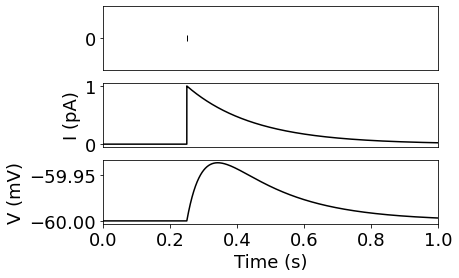

In [7]:
pre_spikes = SpM_pre.spike_trains()
post_I = StM_post[0].I_syn
post_V = StM_post[0].V

subplot(311)
plot(pre_spikes[0], 0 * ones(len(pre_spikes[0])), '|k')
xticks([])
xlim([0, 1])
yticks([0])


subplot(312)
plot(StM_post.t, post_I/pA, 'k')
xticks([])
xlim([0, 1])
ylabel('I (pA)')

subplot(313)
plot(StM_post.t, post_V/mV, 'k')
xlim([0, 1])
xlabel('Time (s)')
ylabel('V (mV)')


This is the general idea of the synapse in spiking IF neurons. The pre-synaptic spike triggers and instant jump of the synaptic state variable, in other words the channel is opened. The state variable then decays exponentially back to zero, parameterized by the synaptic time-constant. The voltage of the neuron is then increased from this current, filtered by the RC circuit of the neuron.

Next, lets connect the spiking neuron dynamics to the underlying mathematical theory of vector matrix products. Again, we are approximating the computations of linear algebra with spiking neuron models. From the IFR theory, we know how the spiking rate relates to the input currents, and this quantity corresponds to the vector coefficients in the matrix-vector product.

We know that there is also a non-linear transfer function induced by the spiking mechanism. Lets bring in the IFR theory to apply this transfer function to the outputs.

In [8]:
def ifr(Id):
    # the theory doesn't work for negative inputs, 
    # we know that these will lead to 0 output spikes, so can just set to 0.
    Id[Id<0] = 0
    t_spike = C_Ax / g_l * np.log((Id+g_l*(E_l - V_r))/(Id+g_l*(E_l - V_t))) + tref
    fr = 1/t_spike
    
    # Fix the nan values 
    fr[isnan(fr)] = 0
    
    return fr

WARNING    /opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: invalid value encountered in log
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


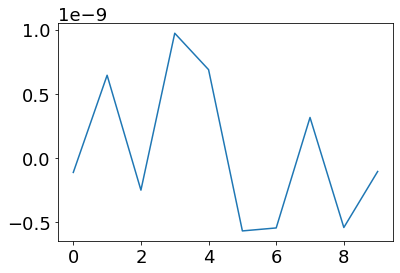

In [9]:
N_pre = 15
N_post = 10

pre_vec = np.zeros(N_pre) * nA
pre_vec[np.random.randint(N_pre)] = 60 * pA 
pre_vec[np.random.randint(N_pre)] = 90 * pA
pre_vec[np.random.randint(N_pre)] = 120 * pA

weights = 20*np.random.randn(N_pre, N_post) 

post_currents = np.dot(weights.T * pA/Hz, ifr(pre_vec))

plot(post_currents)

WARNING    /opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: invalid value encountered in log
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


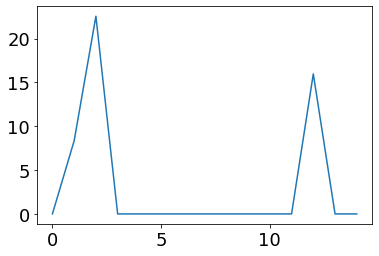

In [10]:
plot(ifr(pre_vec))

WARNING    /opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: invalid value encountered in log
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


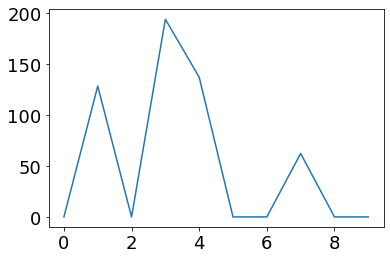

In [11]:
plot(ifr(post_currents))

So do note that we also have to consider how the units that we use in the vector model match the units in the physical spiking model. There will effectively be some scale factors that we need to deal with to make sure that the units match. Generally, the values in the vectors will be in spikes per second, and the values in the weight matrix will be in pico-amps.

Lets plug in the values of the linear algebra model into the spiking dynamic model and observe the outputs. Remember that the IFR is an equilibrium approximation so we will also note the dynamics and the equilibrium result.


In [12]:

G_pre = NeuronGroup(N_pre, model=eqs_if, 
                     threshold='V>V_t', 
                     reset='V=V_r', 
                     refractory=tref)

G_post = NeuronGroup(N_post, model=eqs_if, 
                     threshold='V>V_t',
                     reset='V=V_r', 
                     refractory=tref)

S_pre_post = Synapses(G_pre, G_post, s_eqs, 
                      on_pre=s_on_pre)

# Input connections
S_pre_post.connect()
S_pre_post.w = weights.flatten()

# Set initial conditions
G_pre.V = E_l * ones(N_pre)
G_post.V = E_l * ones(N_post)

# Set inputs
G_pre.I_ext = pre_vec

# Monitor the simulation
SpM_pre = SpikeMonitor(G_pre)
StM_pre = StateMonitor(G_pre, True, record=True)
SpM_post = SpikeMonitor(G_post)
StM_post = StateMonitor(G_post, True, record=True)

# Build the simulation network
ifr_net = Network()
ifr_net.add(G_pre)
ifr_net.add(G_post)
ifr_net.add(S_pre_post)
ifr_net.add(SpM_pre)
ifr_net.add(StM_pre)
ifr_net.add(SpM_post)
ifr_net.add(StM_post)

ifr_net.store('init')

In [13]:
run_time = 2.0 * second
ifr_net.restore('init')
tst = time.time()
ifr_net.run(run_time)
print("elapsed", time.time() - tst)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.02s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'exact' (took 0.09s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_1', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]


elapsed 8.703401803970337


Text(0, 0.5, 'Neuron')

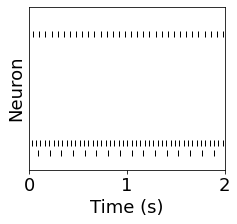

In [14]:
pre_spikes = SpM_pre.spike_trains()
tot_pre_spikes = np.zeros(N_pre)
fr_pre = np.zeros(N_pre)

figure(figsize=(3.5,3))

for i in range(len(pre_spikes)):
    plot(pre_spikes[i] / second, i * ones(len(pre_spikes[i])), '|k')
    
    if len(pre_spikes[i]) > 1:
                # estimate based on total spikes during simulation
        tot_pre_spikes[i] = len(pre_spikes[i])
        

        # estimate based on time between spikes
        fr_pre[i] = 1.0 / np.mean(np.diff(pre_spikes[i]))
    
ylim([0-0.5, N_pre-0.5])
xlim([0, run_time/second])
yticks([])
xlabel('Time (s)')
ylabel('Neuron')

WARNING    /opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: invalid value encountered in log
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


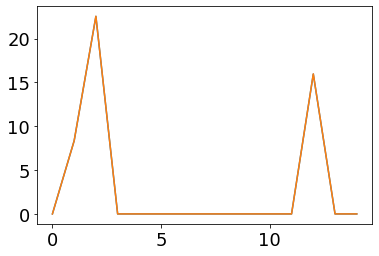

In [15]:
plot(fr_pre)
plot(ifr(pre_vec))

Text(0, 0.5, 'Neuron')

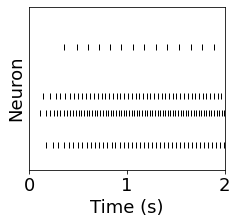

In [16]:
post_spikes = SpM_post.spike_trains()
tot_spikes = np.zeros(N_post)
fr_post = np.zeros(N_post)
fr_post_filt = np.zeros(N_post)

figure(figsize=(3.5,3))

for i in range(len(post_spikes)):
    plot(post_spikes[i] / second, i * ones(len(post_spikes[i])), '|k')
    
    if len(post_spikes[i]) > 1:
                # estimate based on total spikes during simulation
        tot_spikes[i] = len(post_spikes[i])

        # estimate based on time between spikes
        fr_post[i] = 1.0 / np.mean(np.diff(post_spikes[i]))
        
        # same estimate, but ignore the beginning
        spikes_filt = post_spikes[i][post_spikes[i] > 1.0 * second]
        
        fr_post_filt[i] = 1.0 / np.mean(np.diff(spikes_filt))
    
ylim([0-0.5, N_post-0.5])
xlim([0, run_time/second])
yticks([])
xlabel('Time (s)')
ylabel('Neuron')

WARNING    /opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: invalid value encountered in log
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


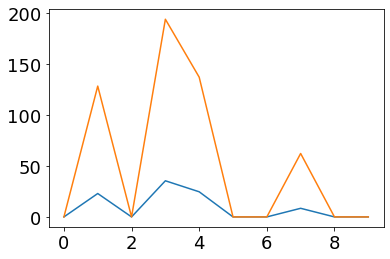

In [17]:
plot(fr_post)
plot(ifr(post_currents))

WARNING    /opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: invalid value encountered in log
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


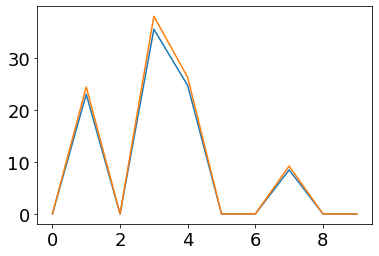

In [18]:
plot(fr_post)
plot(ifr(post_currents/(second/tau_s)))

WARNING    /opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: invalid value encountered in log
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


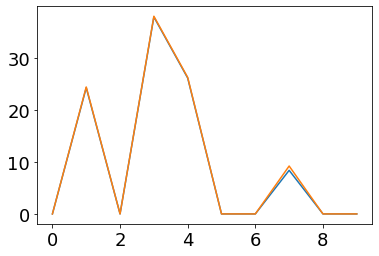

In [19]:
plot(fr_post_filt)
plot(ifr(post_currents/(second/tau_s)))

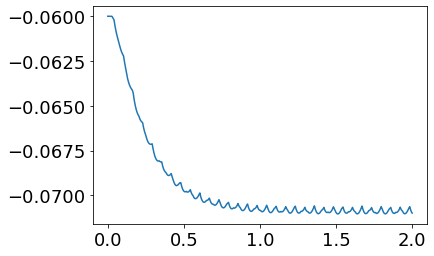

In [20]:
plot(StM_post.t, StM_post.V[8])